In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import itertools
from matplotlib import pyplot as plt
from copy import deepcopy
import os, sys
import random
import json
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_prediction
from sahi.predict import get_sliced_prediction
import re
from tqdm import tqdm
import torch
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import Counter
from pathlib import Path

from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches

import plotly.graph_objects as go
import plotly.express as px

from src.mapping_functions import *

In [ ]:
# Base path
calib_path = Path("data/Wildtrack/calibrations")

# Load extrinsics
extrinsics = {}
extr_files = ["CVLab1", "CVLab2", "CVLab3", "CVLab4", "IDIAP1", "IDIAP2", "IDIAP3"]

for name in extr_files:
    fs = cv.FileStorage(str(calib_path / "extrinsic" / f"extr_{name}.xml"), cv.FILE_STORAGE_READ)
    rvec_node = fs.getNode('rvec')
    tvec_node = fs.getNode('tvec')
    
    extrinsics[name] = {
        'rvec': np.array([rvec_node.at(i).real() for i in range(int(rvec_node.size()))]),
        'tvec': np.array([tvec_node.at(i).real() for i in range(int(tvec_node.size()))])
    }
    fs.release()

# Load intrinsics
intrinsics = {}
intr_files = ["CVLab1", "CVLab2", "CVLab3", "CVLab4", "IDIAP1", "IDIAP2", "IDIAP3"]

for name in intr_files:
    fs = cv.FileStorage(str(calib_path / "intrinsic_zero" / f"intr_{name}.xml"), cv.FILE_STORAGE_READ) # Our images are already undistorted; use intrinsic_zero
    intrinsics[name] = {
        'camera_matrix': fs.getNode('camera_matrix').mat(),
        'dist_coeffs': fs.getNode('distortion_coefficients').mat().flatten()
    }
    fs.release()


# Access example:
# extrinsics['CVLab1']['rvec']  # rotation vector (3,)
# extrinsics['CVLab1']['tvec']  # translation vector (3,)
# intrinsics['CVLab1']['camera_matrix']  # 3x3 camera matrix
# intrinsics['CVLab1']['dist_coeffs']  # distortion coefficients (5,)

In [3]:
def load_wildtrack_images(image_dir, num_images=None):
    folders = [f"C{i}" for i in range(1, 8)]

    # Use the first folder to define frame list
    base_dir = os.path.join(image_dir, folders[0])

    files = [
        f for f in os.listdir(base_dir)
        if f.endswith(".png") and len(os.path.splitext(f)[0]) == 8
    ]

    # Sort by numeric frame id
    files = sorted(files, key=lambda x: int(os.path.splitext(x)[0]))
    selected_files = files[:num_images]

    rows = []

    for fname in tqdm(selected_files):
        frame_num = int(os.path.splitext(fname)[0])
        row = {}

        # Load images from each folder
        for folder in folders:
            img_path = os.path.join(image_dir, folder, fname)
            if os.path.exists(img_path):
                row[folder] = cv.imread(img_path)
            else:
                row[folder] = None

        # Store the real frame id last
        row["frame_id"] = frame_num
        rows.append(row)

    df = pd.DataFrame(rows)
    df.index = range(len(df))
    return df
    
IMAGE_PATH = "data/Wildtrack/image_subsets"
num_images = 10
image_df = load_wildtrack_images(IMAGE_PATH, num_images=num_images)

100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


In [4]:
CAMERA_NAMES = [f'C{i}' for i in range(1, 8)]

In [5]:
def create_camera_animation(frames, save_path, folder_path="saved_files", fps=30):
    num_frames = len(frames)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    
    # Initialize with first frame
    im = ax.imshow(
        cv.cvtColor(frames[0], cv.COLOR_BGR2RGB)
    )
    title = ax.set_title(f'Frame 1/{num_frames}', fontsize=14, fontweight='bold')
    
    def update(frame_idx):
        im.set_array(
            cv.cvtColor(frames[frame_idx], cv.COLOR_BGR2RGB)
        )
        title.set_text(f'Frame {frame_idx + 1}/{num_frames}')
        return [im, title]
    
    # Create animation
    anim = FuncAnimation(
        fig, update,
        frames=num_frames,
        interval=1000/fps,
        blit=True,
        repeat=True
    )
    
    # Save animation
    if save_path.endswith('.gif'):
        anim.save(f"{folder_path}/{save_path}", writer='pillow', fps=fps)
    else:
        anim.save(f"{folder_path}/{save_path}", writer='ffmpeg', fps=fps, dpi=100)
    
    plt.close()
    print(f'Animation saved to {folder_path}/{save_path}')
    
    return anim


# Usage:
cam = 'C4'
anim = create_camera_animation(image_df[cam].tolist(), save_path=f'camera_animation_{cam}.mp4', fps=5)

# For inline viewing in Jupyter:
from IPython.display import HTML
HTML(anim.to_html5_video())

Animation saved to saved_files/camera_animation_C4.mp4


In [245]:
def visualize_predictions(
    image,
    bboxes,
    scores,
    categories,
    score_threshold=0.5,
    figsize=(16, 12),
    show_labels=True,
    show_scores=True,
    font_size=10,
    box_thickness=2
):
    """
    Visualize bounding box predictions on an image.
    
    Args:
        image: Input image (numpy array, BGR or RGB)
        bboxes: List of bounding boxes in xyxy format [[x1, y1, x2, y2], ...]
        scores: List of confidence scores
        categories: List of category names
        score_threshold: Minimum score to display (default: 0.5)
        figsize: Figure size (default: (16, 12))
        show_labels: Whether to show category labels (default: True)
        show_scores: Whether to show confidence scores (default: True)
        font_size: Font size for labels (default: 10)
        box_thickness: Thickness of bounding box lines (default: 2)
    """
    # Convert BGR to RGB if needed (OpenCV uses BGR)
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Assume it might be BGR, convert to RGB for display
        display_image = image.copy()
        if display_image.max() > 1:
            display_image = display_image.astype(np.uint8)
    else:
        display_image = image
    
    # Create figure and axis
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(
        cv.cvtColor(display_image, cv.COLOR_BGR2RGB)
    )
    
    # Generate unique colors for each category
    unique_categories = list(set(categories))
    category_colors = {}
    cmap = plt.get_cmap('tab10')
    for idx, cat in enumerate(unique_categories):
        category_colors[cat] = cmap(idx % 10)
    
    # Filter by score threshold
    filtered_indices = [i for i, score in enumerate(scores) if score >= score_threshold]
    
    # Draw bounding boxes
    for idx in filtered_indices:
        bbox = bboxes[idx]
        score = scores[idx]
        category = categories[idx]
        
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        
        # Get color for this category
        color = category_colors[category]
        
        # Create rectangle patch
        rect = patches.Rectangle(
            (x1, y1), 
            width, 
            height,
            linewidth=box_thickness,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label with background
        if show_labels or show_scores:
            label_parts = []
            if show_labels:
                label_parts.append(category)
            if show_scores:
                label_parts.append(f'{score:.2f}')
            label = ' '.join(label_parts)
            
            # Add text with background box
            ax.text(
                x1, 
                y1 - 5,
                label,
                fontsize=font_size,
                color='white',
                bbox=dict(
                    boxstyle='round,pad=0.3',
                    facecolor=color,
                    alpha=0.7,
                    edgecolor='none'
                ),
                verticalalignment='bottom'
            )
    
    # Add legend with category counts
    legend_elements = []
    for cat in unique_categories:
        count = sum(1 for i in filtered_indices if categories[i] == cat)
        legend_elements.append(
            patches.Patch(
                facecolor=category_colors[cat],
                label=f'{cat} ({count})'
            )
        )
    
    ax.legend(
        handles=legend_elements,
        loc='upper right',
        fontsize=font_size,
        framealpha=0.8
    )
    
    ax.set_title(
        f'Object Detection Results (Threshold: {score_threshold})\n'
        f'Total Detections: {len(filtered_indices)}',
        fontsize=font_size + 4,
        pad=20
    )
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*50}")
    print(f"Detection Summary")
    print(f"{'='*50}")
    print(f"Total detections: {len(bboxes)}")
    print(f"Detections above threshold ({score_threshold}): {len(filtered_indices)}")
    print(f"\nCategory breakdown:")
    for cat in unique_categories:
        count = sum(1 for i in filtered_indices if categories[i] == cat)
        avg_score = np.mean([scores[i] for i in filtered_indices if categories[i] == cat])
        print(f"  {cat}: {count} (avg score: {avg_score:.3f})")
    print(f"{'='*50}\n")

In [163]:
model_path = "yolo-models/yolo11n.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.3,
    device="cpu"
)

In [158]:
def predict(
    image,
    detection_model,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
):
    """
    Returns in xyxy format.
    """
    objects = get_sliced_prediction(
        image=image,
        detection_model=detection_model,
        slice_height=slice_height,
        slice_width=slice_width,
        overlap_height_ratio=overlap_height_ratio,
        overlap_width_ratio=overlap_width_ratio,
    ).object_prediction_list

    bboxes = [o.bbox.to_xyxy() for o in objects]
    scores = [o.score.value for o in objects]
    cat = [o.category.name for o in objects]

    return bboxes, scores, cat

In [242]:
IMAGE_INDEX = 1

####
full_data = dict()
for cam in CAMERA_NAMES:
    bboxes, scores, cat = predict(image_df[cam][IMAGE_INDEX], detection_model)
    full_data[cam] = {
        'bboxes': bboxes,
        'scores': scores,
        'categories': cat
    }

Performing prediction on 15 slices.
Performing prediction on 15 slices.
Performing prediction on 15 slices.
Performing prediction on 15 slices.
Performing prediction on 15 slices.
Performing prediction on 15 slices.
Performing prediction on 15 slices.


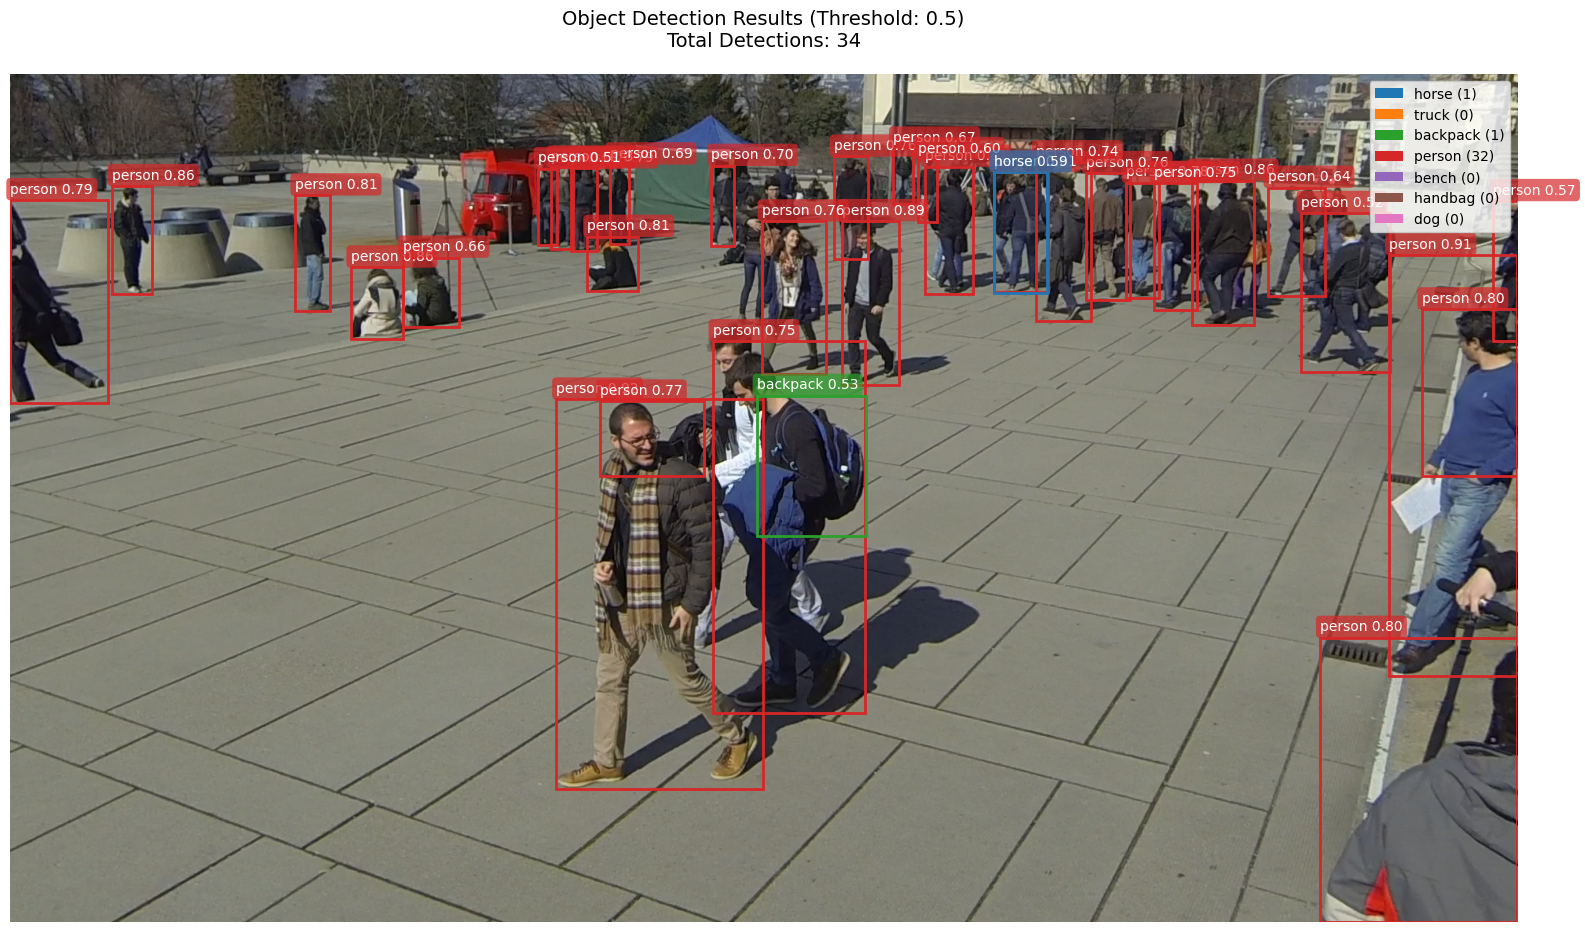


Detection Summary
Total detections: 48
Detections above threshold (0.5): 34

Category breakdown:
  horse: 1 (avg score: 0.593)
  truck: 0 (avg score: nan)
  backpack: 1 (avg score: 0.531)
  person: 32 (avg score: 0.747)
  bench: 0 (avg score: nan)
  handbag: 0 (avg score: nan)
  dog: 0 (avg score: nan)



In [246]:
cam = "C1"
visualize_predictions(
    image=image_df[cam][IMAGE_INDEX],
    bboxes=full_data[cam]['bboxes'],
    scores=full_data[cam]['scores'],
    categories=full_data[cam]['categories'],
    score_threshold=0.5
)

In [157]:
def convert_camera_name_to_filename(camera_name: str) -> str:
    """Convert camera name to corresponding filename index."""
    calibration_filenames = ["CVLab1", "CVLab2", "CVLab3", "CVLab4", "IDIAP1", "IDIAP2", "IDIAP3"]

    conversion_dict = dict(zip(CAMERA_NAMES, calibration_filenames))
    return conversion_dict.get(camera_name, None)

def image_points_to_rays(points, camera_name):

    """Convert multiple 2D image points to 3D rays in world coordinates."""
    # load intrinsics and extrinsics; no need for distortion correction as points are already undistorted
    filename = convert_camera_name_to_filename(camera_name)

    K = intrinsics[filename]['camera_matrix']
    rvec = extrinsics[filename]['rvec']
    tvec = extrinsics[filename]['tvec']

    # Convert rotation vector to matrix
    R, _ = cv.Rodrigues(rvec)

    # homogeneous coordinates
    p = np.insert(points, 2, 1.0, axis=1)

    # Convert to direction ray (from camera center) using the formal "X = (R'*K^-1*p)/s - R'*T" --> X is a point ray from C=-R'*T along direction "R' * [undistorted point]"
    K_inv = np.linalg.inv(K)

    rays = []
    for i in range(points.shape[0]):
        ray_dir_world = R.T @ (K_inv @ p[i])
        rays.append(ray_dir_world / np.linalg.norm(ray_dir_world))
    rays = np.array(rays)

    # Camera center in world coordinates (ray origin)
    C = -R.T @ tvec

    return C, rays

def world_points_to_image_points(points_3d, camera_name):
    """
    Project multiple 3D world points to 2D image coordinates.
    
    Args:
        points_3d: Nx3 array of 3D points in world coordinates
        camera_name: Name of the camera to project to
        
    Returns:
        points_2d: Nx2 array of 2D image coordinates
    """
    # Load intrinsics and extrinsics
    filename = convert_camera_name_to_filename(camera_name)
    K = intrinsics[filename]['camera_matrix']
    rvec = extrinsics[filename]['rvec']
    tvec = extrinsics[filename]['tvec']
    
    # Convert rotation vector to matrix
    R, _ = cv.Rodrigues(rvec)
    
    # Ensure points_3d is a numpy array
    points_3d = np.array(points_3d)
    
    # Convert 3D points to homogeneous coordinates (Nx4)
    points_3d_homogeneous = np.insert(points_3d, 3, 1.0, axis=1)
    
    # Create the extrinsic matrix [R | T] (3x4)
    RT = np.hstack([R, tvec])
    
    # Project: p = K * [R | T] * P
    # This gives us homogeneous 2D coordinates (3xN)
    points_2d_homogeneous = K @ RT @ points_3d_homogeneous.T
    
    # Convert from homogeneous to cartesian coordinates by dividing by the third coordinate (s)
    points_2d = points_2d_homogeneous[:2, :] / points_2d_homogeneous[2, :]
    
    # Transpose to get Nx2 array
    points_2d = points_2d.T
    
    return points_2d

def world_points_to_image_points(points_3d, camera_name):
    """
    Project multiple 3D world points to 2D image coordinates.
    
    Args:
        points_3d: Nx3 array of 3D points in world coordinates
        camera_name: Name of the camera to project to
        
    Returns:
        points_2d: Nx2 array of 2D image coordinates
    """
    # Load intrinsics and extrinsics
    filename = convert_camera_name_to_filename(camera_name)
    K = intrinsics[filename]['camera_matrix']
    rvec = extrinsics[filename]['rvec']
    tvec = extrinsics[filename]['tvec']
    
    # Convert rotation vector to matrix
    R, _ = cv.Rodrigues(rvec)
    
    # Ensure points_3d is a numpy array
    points_3d = np.array(points_3d)
    
    # Convert 3D points to homogeneous coordinates (Nx4)
    points_3d_homogeneous = np.insert(points_3d, 3, 1.0, axis=1)
    
    # Create the extrinsic matrix [R | T] (3x4)
    tvec = tvec.reshape(-1,1)
    RT = np.hstack([R, tvec])
    
    # Project: p = K * [R | T] * P
    # This gives us homogeneous 2D coordinates (3xN)
    points_2d_homogeneous = K @ RT @ points_3d_homogeneous.T
    
    # Convert from homogeneous to cartesian coordinates by dividing by the third coordinate (s)
    points_2d = points_2d_homogeneous[:2, :] / points_2d_homogeneous[2, :]
    
    # Transpose to get Nx2 array
    points_2d = points_2d.T
    
    return points_2d

def quad_area(rays):
    """Fast area calculation for planar 3D quadrilateral using diagonals."""
    d1 = rays[2] - rays[0]
    d2 = rays[3] - rays[1]
    return 0.5 * np.linalg.norm(np.cross(d1, d2))


In [247]:
center_data = dict() # format: {camera_name: camera_center}
ray_slice_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [ray1, ray2, ...]} initialize with empty list
ray_slice_area_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
)
category_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [cat1, cat2, ...]} initialize with empty list
score_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [score1, score2, ...]} initialize with empty list



for name in CAMERA_NAMES:
    data = full_data[name]
    for b, score, cat in zip(data['bboxes'], data['scores'], data['categories']):

        points = np.array(
            [
                [b[0], b[1]],
                [b[2], b[1]],
                [b[2], b[3]],
                [b[0], b[3]],
            ]
        )
    

        C, rays = image_points_to_rays(points, name)
        area = quad_area(rays)

        ## Store data 
        center_data[name] = C
        ray_slice_data[name].append(rays)
        ray_slice_area_data[name].append(area)
        category_data[name].append(cat)
        score_data[name].append(score)



In [308]:
def add_camera_visuals(
    fig,
    camera_center,
    camera_name,
    extrinsics,
    scale=200,
    arrow_size=100
):
    C = np.asarray(camera_center).reshape(3)

    # ---- Camera center ----
    fig.add_trace(
        go.Scatter3d(
            x=[C[0]], y=[C[1]], z=[C[2]],
            mode='markers+text',
            marker=dict(size=5, color='red'),
            text=[camera_name],
            textposition='top center',
            name=f'Camera {camera_name} Center'
        )
    )

    # ---- Extrinsics ----
    filename = convert_camera_name_to_filename(camera_name)

    rvec = np.asarray(extrinsics[filename]['rvec']).reshape(3)
    R, _ = cv.Rodrigues(rvec)

    # OpenCV: world -> camera
    # We need camera -> world
    R_world = R.T

    # ---- Camera forward direction (+Z in camera frame) ----
    ray_camera = np.array([0.0, 0.0, 1.0])

    camera_direction = R_world @ ray_camera
    camera_direction /= np.linalg.norm(camera_direction)

    end_point = C + camera_direction * scale

    # ---- Direction line ----
    fig.add_trace(
        go.Scatter3d(
            x=[C[0], end_point[0]],
            y=[C[1], end_point[1]],
            z=[C[2], end_point[2]],
            mode='lines',
            line=dict(width=3),
            name=f'Camera {camera_name} Direction'
        )
    )

    # ---- Arrowhead ----
    fig.add_trace(
        go.Cone(
            x=[end_point[0]],
            y=[end_point[1]],
            z=[end_point[2]],
            u=[camera_direction[0]],
            v=[camera_direction[1]],
            w=[camera_direction[2]],
            sizemode='absolute',
            sizeref=arrow_size,
            showscale=False,
            colorscale=[[0, 'blue'], [1, 'blue']],
            name=f'Camera {camera_name} Arrow',
            showlegend=False
        )
    )


In [309]:
# plot rays in 3D, with camera center
ray_length = 2000 # length of the rays for visualization
num_slices = 5

fig = go.Figure()
for name in CAMERA_NAMES:
    C = center_data[name]
    slices = ray_slice_data[name]
    slice_scores = score_data[name]

    # Plot camera center and rotation vector
    add_camera_visuals(
        fig, 
        C, 
        name, 
        extrinsics,
    )

    # Plot rays
    _, sorted_slices = zip(*sorted(zip(slice_scores, slices), key=lambda x: x[0], reverse=True))
    for idx, s in enumerate(sorted_slices):
        if idx > num_slices:
            break
        
        # color by slice index
        c = f"rgb(\
            {random.randint(0, 255)},\
            {random.randint(0, 255)},\
            {random.randint(0, 255)})"

        for ray in s:
            ray_end = C + ray * ray_length
            fig.add_trace(
                go.Scatter3d(
                    x=[C[0], ray_end[0]],
                    y=[C[1], ray_end[1]],
                    z=[C[2], ray_end[2]],
                    mode='lines',
                    line=dict(color=c, width=2),
                    showlegend=False
                )
            )
        

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    title='3D Camera Rays Visualization'
)
fig.show()
    

In [249]:
def point_in_wedge(point, origin, rays):
    """
    Check if a point is in the wedge formed by rays. Accepts CCW or CW ray orientation.
    """
    v = point - origin
    
    # Compute centroid of the 4 rays (approximate center of wedge)
    centroid = np.mean(rays, axis=0)
    centroid = centroid / np.linalg.norm(centroid)
    
    for i in range(rays.shape[0]):
        ray1 = rays[i]
        ray2 = rays[(i+1) % 4]
        
        normal = np.cross(ray1, ray2)

        
        # Determine if normal should point inward or outward
        # by checking which side the centroid is on
        if np.dot(centroid, normal) > 0:
            # Centroid is on positive side, so that's "inside"
            if np.dot(v, normal) < 0:
                return False
        else:
            # Centroid is on negative side
            if np.dot(v, normal) > 0:
                return False
    
    return True

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [250]:
## Variables
category_to_track = 'person'

xrange = (-1000, 1500)
yrange = (-1500, 2500)
zrange = (-400, 400)
spacing = 100

############################
def ndindex_range(ranges, step):
    return itertools.product(*(range(start, end, step) for start, end in ranges))

voxel_points = list(ndindex_range((xrange, yrange, zrange), spacing))
# format: Dictionary with categories, each with 3d point keys, each with a dictionary of cameras as keys, each with a dictionary of ("bbox_idx", "bbox_weight") as keys
voxel_dict = dict(zip(
    voxel_points, 
    [ 
        deepcopy(dict(zip( CAMERA_NAMES, [
            deepcopy({
                "slice_idx": [],
                "slice_weight": [],
            }) for _ in CAMERA_NAMES
        ] ))) for _ in voxel_points 
    ]
))

points_to_remove = []
for point in tqdm(voxel_points):
    in_any_slice = False # lets you remove points with nothing going on
    for cam in CAMERA_NAMES:
        point_info = voxel_dict[point][cam]

        ray_slices = ray_slice_data[cam]
        slice_areas = ray_slice_area_data[cam]
        categories = category_data[cam]
        slice_scores = score_data[cam]
        
        for slice_idx, (rays, area, score, cat) in enumerate(zip(ray_slices, slice_areas, slice_scores, categories)):
            if cat.lower() != category_to_track.lower(): # category filtering
                continue

            in_wedge = point_in_wedge(
                point=point,
                origin=C,
                rays=rays
            )

            if in_wedge:
                in_any_slice = True

                point_info['slice_idx'].append(slice_idx)
                
                distance_squared = np.sum(np.square(C + point))
                point_info['slice_weight'].append(   # basically confidence score
                    score / (area * distance_squared)
                )

    # remove points with nothing going on
    if not in_any_slice:
        points_to_remove.append(point)

100%|██████████| 8000/8000 [00:57<00:00, 138.69it/s]


In [251]:
for point in points_to_remove:
    try:
        del voxel_dict[point]
    except:
        continue

In [252]:
voxel_bbox_associations = dict(zip(
    voxel_dict.keys(), 
    [ 
        deepcopy(dict(zip( CAMERA_NAMES, [ None for _ in CAMERA_NAMES] ))) for _ in voxel_dict 
    ]
))

voxel_bbox_scores = dict(zip(
    voxel_dict.keys(), 
    [ 
        0.0 for _ in voxel_dict 
    ]
))

for point in tqdm(voxel_dict):
    point_info = voxel_dict[point]

    for cam in CAMERA_NAMES:
        if len(point_info[cam]['slice_idx']) == 0:
            continue

        weights = np.array(point_info[cam]["slice_weight"])
        idxs = np.array(point_info[cam]["slice_idx"])

        best_idx = idxs[np.argmax(weights)]  # find highest weight

        # update match
        voxel_bbox_associations[point][cam] = best_idx

        # update scores
        voxel_bbox_scores[point] += np.max(weights)


100%|██████████| 2408/2408 [00:00<00:00, 165647.90it/s]


In [256]:
import numpy as np
from collections import defaultdict

def perform_nms(voxel_bbox_scores, voxel_bbox_associations):
    """
    Perform non-maximum suppression on voxels based on bounding box associations.
    
    For each unique combination of bounding box associations across cameras,
    only the voxel with the highest score is retained.
    
    Args:
        voxel_bbox_scores: dict mapping voxel coordinates to scores
        voxel_bbox_associations: dict mapping voxel coordinates to camera-bbox associations
        
    Returns:
        dict: filtered voxel_bbox_scores containing only maximum scoring voxels
        dict: corresponding filtered voxel_bbox_associations
    """
    # Group voxels by their bounding box association signature
    association_groups = defaultdict(list)
    
    for voxel, associations in voxel_bbox_associations.items():
        # Create a hashable key from the association pattern
        # Convert dict to tuple of (camera, bbox_id) pairs, sorted by camera
        assoc_key = tuple(sorted(
            (cam, bbox_id) for cam, bbox_id in associations.items()
        ))
        
        score = voxel_bbox_scores[voxel]
        association_groups[assoc_key].append((voxel, score))
    
    # For each group, keep only the voxel with maximum score
    filtered_scores = {}
    filtered_associations = {}
    
    for assoc_key, voxels in association_groups.items():
        # Find voxel with maximum score
        max_voxel, max_score = max(voxels, key=lambda x: x[1])
        
        filtered_scores[max_voxel] = max_score
        filtered_associations[max_voxel] = voxel_bbox_associations[max_voxel]
    
    return filtered_scores, filtered_associations

def perform_weighted_centroid_suppression(voxel_bbox_scores, voxel_bbox_associations):
    """
    Instead of selecting the maximum scoring voxel, compute the weighted centroid
    of voxels with the same bounding box association pattern.
    
    For each unique combination of bounding box associations across cameras,
    all voxels are combined into a single weighted centroid position.
    
    Args:
        voxel_bbox_scores: dict mapping voxel coordinates to scores
        voxel_bbox_associations: dict mapping voxel coordinates to camera-bbox associations
        
    Returns:
        dict: centroid positions (as tuples) mapping to aggregated scores
        dict: corresponding voxel_bbox_associations for each centroid
    """
    # Group voxels by their bounding box association signature
    association_groups = defaultdict(list)
    
    for voxel, associations in voxel_bbox_associations.items():
        # Create a hashable key from the association pattern
        # Convert dict to tuple of (camera, bbox_id) pairs, sorted by camera
        assoc_key = tuple(sorted(
            (cam, bbox_id) for cam, bbox_id in associations.items()
        ))
        
        score = voxel_bbox_scores[voxel]
        association_groups[assoc_key].append((voxel, score))
    
    # For each group, compute weighted centroid
    centroid_scores = {}
    centroid_associations = {}
    
    for assoc_key, voxels in association_groups.items():
        # Extract positions and weights
        positions = np.array([v[0] for v in voxels])  # Nx3 array of voxel positions
        weights = np.array([v[1] for v in voxels])    # N array of scores
        
        # Compute weighted centroid
        total_weight = np.sum(weights)
        weighted_centroid = np.sum(positions * weights[:, np.newaxis], axis=0) / total_weight
        
        # Convert back to tuple for consistency with input format
        centroid_tuple = tuple(weighted_centroid)
        
        # Store the total weight as the score for the centroid
        centroid_scores[centroid_tuple] = total_weight
        
        # Use the association from any voxel in the group (they're all the same)
        centroid_associations[centroid_tuple] = voxel_bbox_associations[voxels[0][0]]
    
    return centroid_scores, centroid_associations


# Perform NMS
filtered_scores, filtered_associations = perform_weighted_centroid_suppression(
    voxel_bbox_scores, voxel_bbox_associations
)

print(f"Original voxels: {len(voxel_bbox_scores)}")
print(f"After NMS: {len(filtered_scores)}")

Original voxels: 2408
After NMS: 196


In [310]:
import plotly.graph_objects as go
import numpy as np
import random

# --- Parameters ---
minimum_matches_for_visual = 2
data_dict = filtered_associations

# --- Create deterministic colors for each bbox pattern ---
def generate_color(key_tuple):
    random.seed(hash(key_tuple) % 2**32)
    return f"rgb({random.randint(50,255)}, {random.randint(50,255)}, {random.randint(50,255)})"

pattern_to_color = {}

# --- Build scatter data ---
xs, ys, zs = [], [], []
colors = []

for (x, y, z), cams in data_dict.items():
    if sum(v is not None for v in cams.values()) < minimum_matches_for_visual:
        continue

    xs.append(x)
    ys.append(y)
    zs.append(z)

    # Turn cam-bbox dict into a tuple signature
    key = tuple(cams.values())

    # If this pattern hasn't been assigned a color yet, add one
    if key not in pattern_to_color:
        pattern_to_color[key] = generate_color(key)

    colors.append(pattern_to_color[key])

# --- Plotly scatter ---
fig = go.Figure(
    data=go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        mode='markers',
        marker=dict(size=4, color=colors, opacity=0.85)
    )
)
# Plot camera centers for reference
for name in CAMERA_NAMES:
    C = center_data[name]
    
    # Plot camera center and rotation vector
    add_camera_visuals(
        fig, 
        C, 
        name, 
        extrinsics,
    )

fig.update_layout(
    scene=dict(aspectmode='data'),
    title="3D Voxel Bounding-Box Pattern Visualization"
)

fig.show()


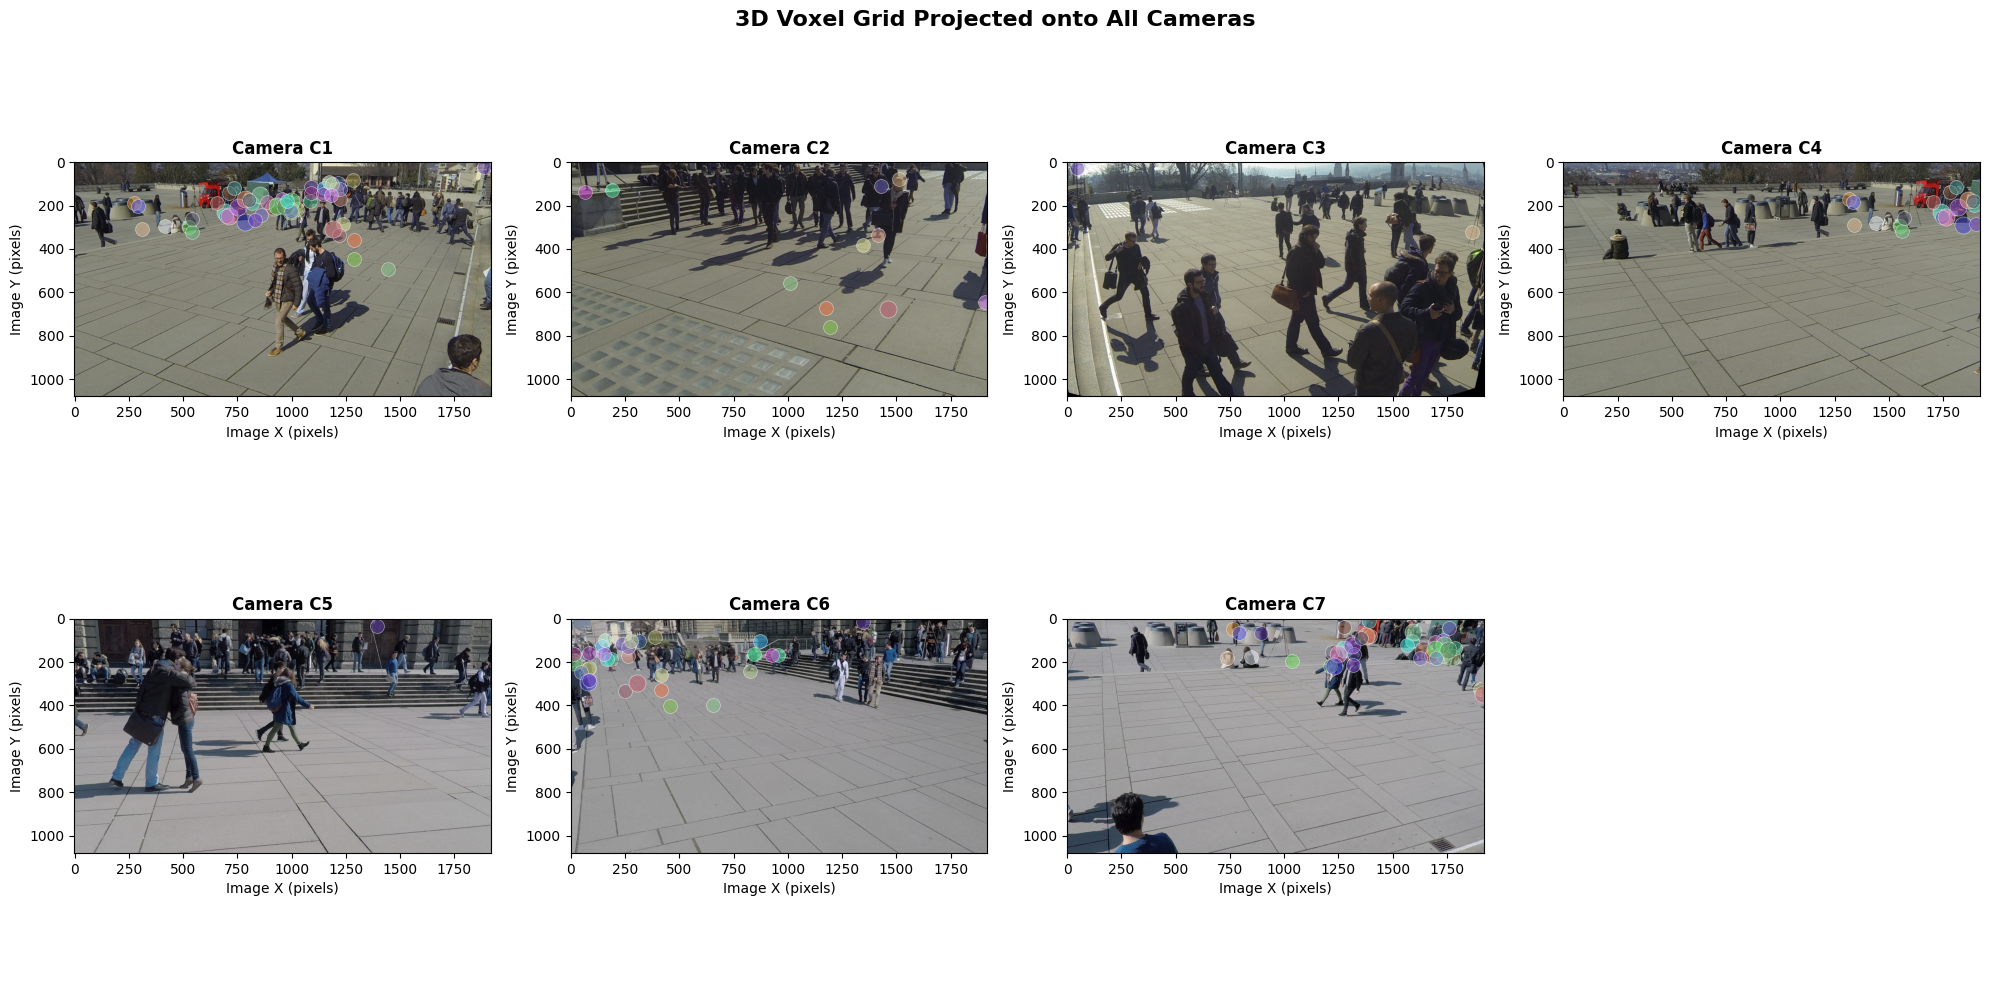

In [311]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import random

# --- Parameters ---
image_index = 0
size_scale = 50  # Scale for marker sizes
opacity = 0.5
minimum_matches_for_visual = 2
data_dict = filtered_associations

# --- Step 1: Extract voxel positions and intensities ---
def generate_color_tuple(key_tuple):
    random.seed(hash(key_tuple) % 2**32)
    return (
        random.randint(50, 255) / 255,
        random.randint(50, 255) / 255,
        random.randint(50, 255) / 255,
    )

# Pre-process data once for all cameras
pattern_to_color = {}
point_positions = []
colors = []
sizes = []

for point, cams in data_dict.items():
    num_matches = sum(v is not None for v in cams.values())
    if num_matches < minimum_matches_for_visual:
        continue
    
    sizes.append(num_matches * size_scale)
    point_positions.append(point)
    
    # Turn cam-bbox dict into a tuple signature
    key = tuple(cams.values())
    
    # If this pattern hasn't been assigned a color yet, add one
    if key not in pattern_to_color:
        pattern_to_color[key] = generate_color_tuple(key)
    
    colors.append(pattern_to_color[key])

# --- Step 2: Create subplots for all cameras ---
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

for cam_idx, camera in enumerate(CAMERA_NAMES):
    ax = axes[cam_idx]
    
    # Project points to this camera
    image_positions = world_points_to_image_points(
        point_positions,
        camera
    )
    
    # Get the image for this camera
    image_overlay = image_df[camera][image_index].copy()
    
    # Filter out points outside the image boundaries
    height, width = image_overlay.shape[:2]
    valid_mask = (
        (image_positions[:, 0] >= 0) & 
        (image_positions[:, 0] < width) &
        (image_positions[:, 1] >= 0) & 
        (image_positions[:, 1] < height)
    )
    
    # Apply the mask to get valid positions, colors, and sizes
    valid_positions = image_positions[valid_mask]
    valid_colors = [colors[i] for i in range(len(colors)) if valid_mask[i]]
    valid_sizes = [sizes[i] for i in range(len(sizes)) if valid_mask[i]]
    
    # Display the image
    ax.imshow(cv.cvtColor(image_overlay, cv.COLOR_BGR2RGB))
    
    # Scatter plot the points
    for i in range(len(valid_positions)):
        ax.scatter(
            valid_positions[i, 0], 
            valid_positions[i, 1],
            s=valid_sizes[i],
            c=[valid_colors[i]],
            alpha=opacity,
            edgecolors='white',
            linewidths=0.5
        )
    
    ax.set_title(f'Camera {camera}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Image X (pixels)')
    ax.set_ylabel('Image Y (pixels)')
    ax.set_aspect('equal', adjustable='box')

# Hide the 8th subplot (we only have 7 cameras)
axes[7].axis('off')

plt.suptitle('3D Voxel Grid Projected onto All Cameras', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
image_positions = world_points_to_image_points(
    np.array(list(zip(xs, ys, zs))),
    camera
    )

## Archived
---

In [22]:
# get unique 
flat_cat = [i for ii in category_data.values() for i in ii]
unique_categories = set(flat_cat)

xrange = (-1000, 1500)
yrange = (-1500, 2500)
zrange = (-400, 400)
spacing = 200

## Code

voxarr = np.zeros(
    (
        (xrange[1]-xrange[0])//spacing, 
        (yrange[1]-yrange[0])//spacing, 
        (zrange[1]-zrange[0])//spacing,
    ),
)

voxel_arrays = dict(
    zip(
        unique_categories,
        [ voxarr.copy() for _ in unique_categories ]
    )
)

for name in tqdm(CAMERA_NAMES):
    C = center_data[name]

    ray_slices = ray_slice_data[name]
    slice_areas = ray_slice_area_data[name]
    categories = category_data[name]
    scores = score_data[name]
    
    for rays, area, s, cat in zip(ray_slices, slice_areas, scores, categories):
        for v_idx in np.ndindex(voxel_arrays[cat].shape):
            point = np.array([
                v_idx[0]*spacing + xrange[0],
                v_idx[1]*spacing + yrange[0],
                v_idx[2]*spacing + zrange[0],
            ])
            
            in_wedge = point_in_wedge(
                point=point,
                origin=C,
                rays=rays
            )

            distance_squared = np.sum(np.square(C + point)) # x**2 + y**2 + z*22
            voxel_arrays[cat][v_idx] += in_wedge * s * 1 / (area * distance_squared)
    

100%|██████████| 7/7 [00:05<00:00,  1.18it/s]


In [ ]:
# Visualize voxel grid for a specific category
category_to_visualize = 'person'  # change as needed
voxel_data = voxel_arrays[category_to_visualize] / np.max(voxel_arrays[category_to_visualize])
threshold = 0

# Prepare coordinates for voxels with values based on threshold
x_coords, y_coords, z_coords = np.where(voxel_data > threshold)
values = voxel_data[x_coords, y_coords, z_coords]

# Create 3D scatter plot
fig = px.scatter_3d(
    x=x_coords * spacing + xrange[0],
    y=y_coords * spacing + yrange[0],
    z=z_coords * spacing + zrange[0],
    color=values,
    size=values,
    title=f'Voxel Grid Visualization for Category: {category_to_visualize}',
    labels={'x': 'X', 'y': 'Y', 'z': 'Z', 'color': 'Voxel Value'}
)

# Plot camera centers for reference
for name in CAMERA_NAMES:
    C = center_data[name]
    fig.add_trace(
        go.Scatter3d(
            x=[C[0]], y=[C[1]], z=[C[2]],
            mode='markers+text',
            marker=dict(size=5, color='red'),
            text=[name],
            textposition='top center',
            name=f'Camera {name} Center',
            showlegend=False
        )
    )

fig.update_layout(scene=dict(aspectmode='data'))
fig.show()

In [ ]:
unique_categories

{'backpack', 'handbag', 'horse', 'person', 'skateboard', 'truck'}

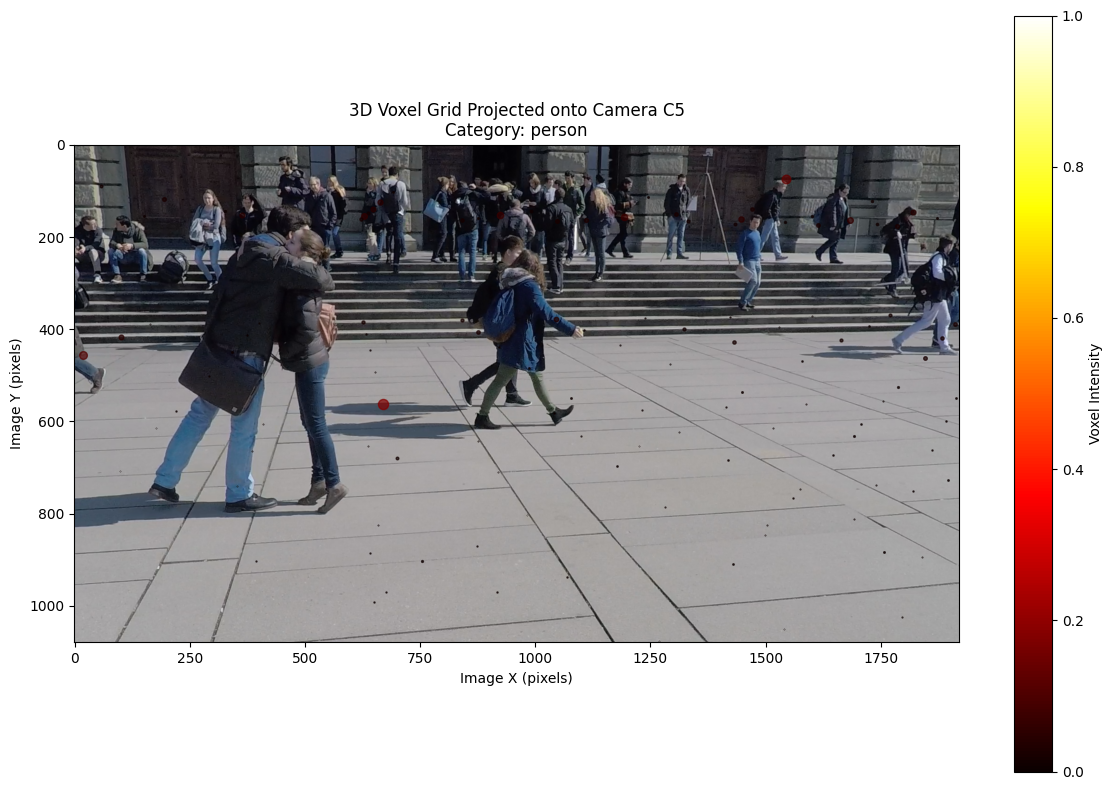

In [ ]:
# visualize on camera plane
camera = "C5"
category_to_visualize = 'person'
voxel_threshold = 0
size_scale = 300

## Code
voxel_data = voxel_arrays[category_to_visualize] / np.max(voxel_arrays[category_to_visualize])
voxel_points = np.array(
    list(np.ndindex(voxel_data.shape))
) * spacing + np.array([xrange[0], yrange[0], zrange[0]])
image_positions = world_points_to_image_points(voxel_points, camera)

## Visualization
image_overlay = image_df[camera][0].copy()

# Get the voxel intensities (flattened to match voxel_points)
voxel_intensities = voxel_data.flatten()

# Filter out points outside the image boundaries and with low intensities
height, width = image_overlay.shape[:2]
valid_mask = (
    (image_positions[:, 0] >= 0) & 
    (image_positions[:, 0] < width) &
    (image_positions[:, 1] >= 0) & 
    (image_positions[:, 1] < height) &
    (voxel_intensities > voxel_threshold)  # Only show voxels with intensity > threshold
)

valid_positions = image_positions[valid_mask]
valid_intensities = voxel_intensities[valid_mask]

# Create a colormap overlay
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(
    cv.cvtColor(image_overlay, cv.COLOR_BGR2RGB)
)

# Scale point sizes by intensity (larger = higher intensity)
point_sizes = valid_intensities * size_scale  # Adjust multiplier to control max size

# Scale alpha by intensity too (more opaque = higher intensity)
point_alpha = 0.7  # Max alpha of 0.7 to keep image visible

# Plot the projected voxels with colors, sizes, and alphas based on intensity
for i in range(len(valid_positions)):
    ax.scatter(
        valid_positions[i, 0], 
        valid_positions[i, 1],
        c=[valid_intensities[i]],
        cmap='hot',
        alpha=point_alpha,
        s=point_sizes[i],
        vmin=0,
        vmax=1
    )

# Create a dummy scatter for the colorbar
scatter = ax.scatter(
    [], [],
    c=[],
    cmap='hot',
    vmin=0,
    vmax=1
)

plt.colorbar(scatter, ax=ax, label='Voxel Intensity')
ax.set_title(f'3D Voxel Grid Projected onto Camera {camera}\nCategory: {category_to_visualize}')
ax.set_xlabel('Image X (pixels)')
ax.set_ylabel('Image Y (pixels)')
plt.tight_layout()
plt.show()

In [ ]:
# get unique 
flat_cat = [i for ii in category_data.values() for i in ii]
unique_categories = set(flat_cat)

xrange = (-1000, 1500)
yrange = (-1500, 2500)
zrange = (-400, 400)
spacing = 200

## Code

voxarr = np.zeros(
    (
        (xrange[1]-xrange[0])//spacing, 
        (yrange[1]-yrange[0])//spacing, 
        (zrange[1]-zrange[0])//spacing,
    ),
)

voxel_arrays = dict(
    zip(
        unique_categories,
        [ voxarr.copy() for _ in unique_categories ]
    )
)

for name in tqdm(CAMERA_NAMES):
    C = center_data[name]

    ray_slices = ray_slice_data[name]
    slice_areas = ray_slice_area_data[name]
    categories = category_data[name]
    scores = score_data[name]
    
    for rays, area, s, cat in zip(ray_slices, slice_areas, scores, categories):
        for v_idx in np.ndindex(voxel_arrays[cat].shape):
            point = np.array([
                v_idx[0]*spacing + xrange[0],
                v_idx[1]*spacing + yrange[0],
                v_idx[2]*spacing + zrange[0],
            ])
            
            in_wedge = point_in_wedge(
                point=point,
                origin=C,
                rays=rays
            )

            distance_squared = np.sum(np.square(C + point)) # x**2 + y**2 + z*22
            voxel_arrays[cat][v_idx] += in_wedge * s * 1 / (area * distance_squared)
    